## 1. Data Import and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

/Users/anxiousviking/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Data import
data = pd.read_csv('Signature.csv')

# Initial exploration
print("Head of the dataset:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nDataset Description:")
print(data.describe())

# Check for null values
print("\nNull Value Check:")
print(data.isnull().sum())

Head of the dataset:
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  10   
1               0       0    0  ...                   1   
2               0       0    0  ...                  86   
3               0       0    0  ...                  57   
4               0       0    0  ...                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61 

## 2. Data Cleaning

In [3]:
# Drop rows where either 'count' or 'srv_count' is null
data = data.dropna(subset=['count', 'srv_count'])

# Confirm null values are removed
print("\nAfter dropping nulls:")
print(data.isnull().sum().sum())  # Should be 0

# Identify and drop columns with a single unique value, excluding the target variable
columns_to_drop = [col for col in data.columns if col != 'class' and data[col].nunique() <= 1]
data.drop(columns=columns_to_drop, inplace=True)

print("\nRemaining columns after dropping single unique value columns:")
print(data.columns)


After dropping nulls:
0

Remaining columns after dropping single unique value columns:
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_guest_login', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


## 3. Data Visualization

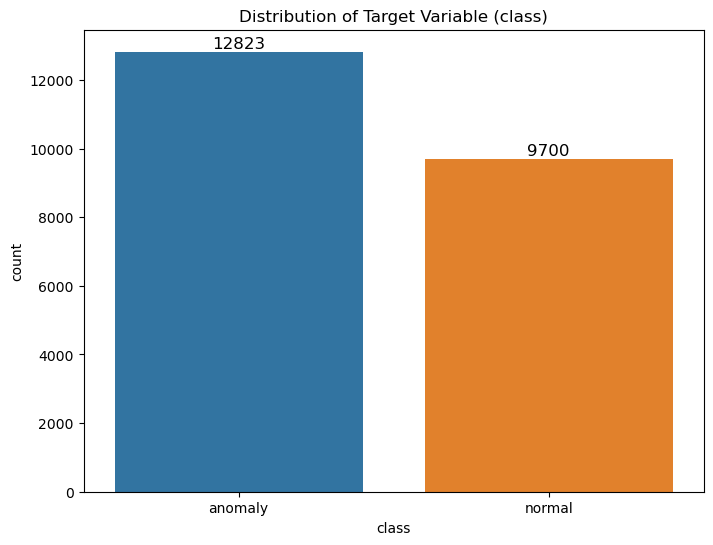

In [4]:
# Target variable distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='class', data=data)
plt.title('Distribution of Target Variable (class)')

# Add counts on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

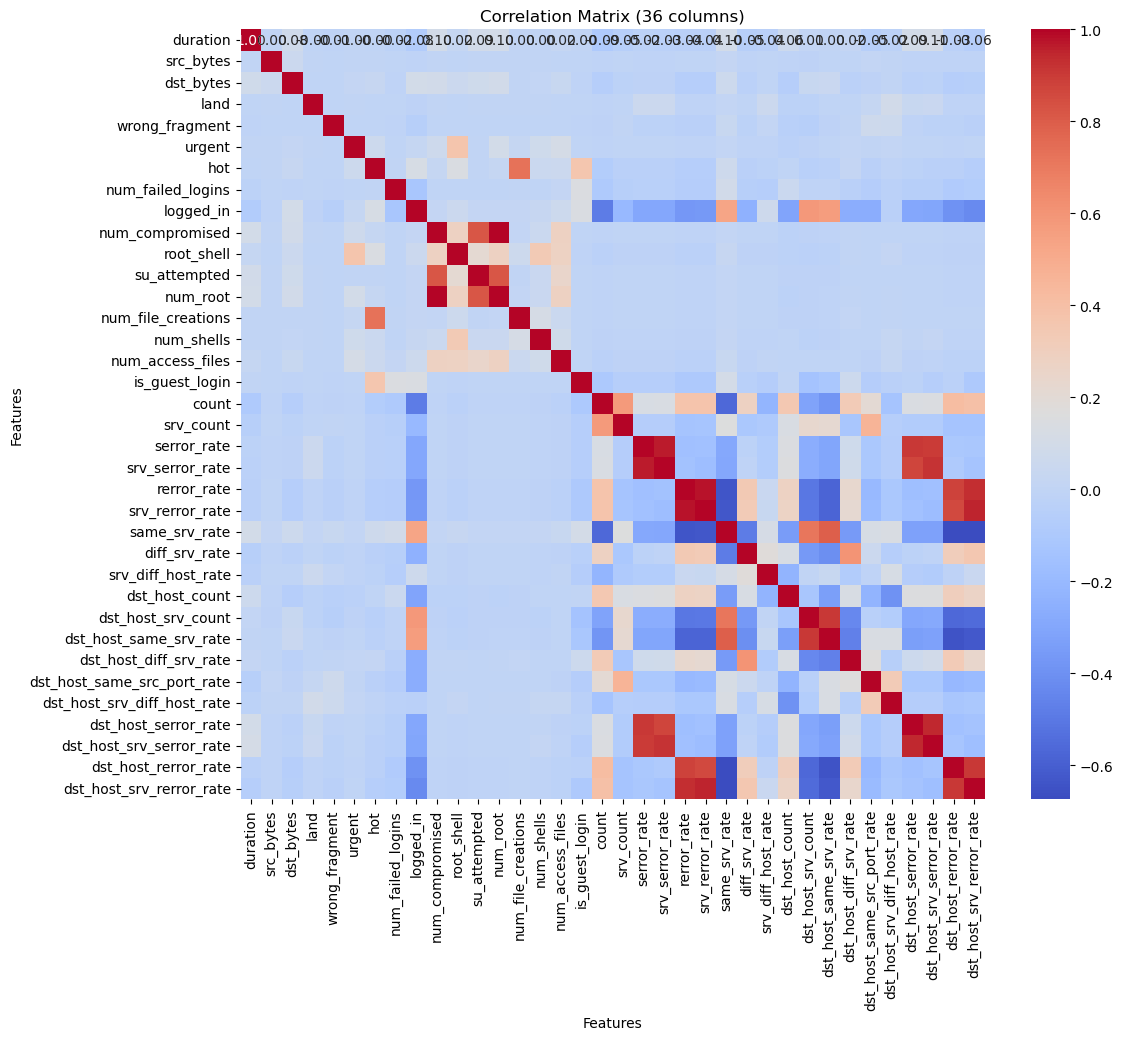


List of Correlation Values:
duration                  duration                1.000000
num_compromised           num_root                0.995960
srv_rerror_rate           rerror_rate             0.975512
srv_serror_rate           serror_rate             0.966345
dst_host_srv_rerror_rate  srv_rerror_rate         0.947798
                                                    ...   
srv_rerror_rate           same_srv_rate          -0.633649
rerror_rate               same_srv_rate          -0.637861
dst_host_same_srv_rate    dst_host_rerror_rate   -0.642341
same_srv_rate             dst_host_rerror_rate   -0.671484
dst_host_srv_rerror_rate  same_srv_rate          -0.673930
Length: 631, dtype: float64


In [5]:
# Filter numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate and plot correlation matrix for numeric columns only
correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Correlation Matrix ({len(numeric_cols)} columns)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

# Print correlation values
print("\nList of Correlation Values:")
print(correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates())

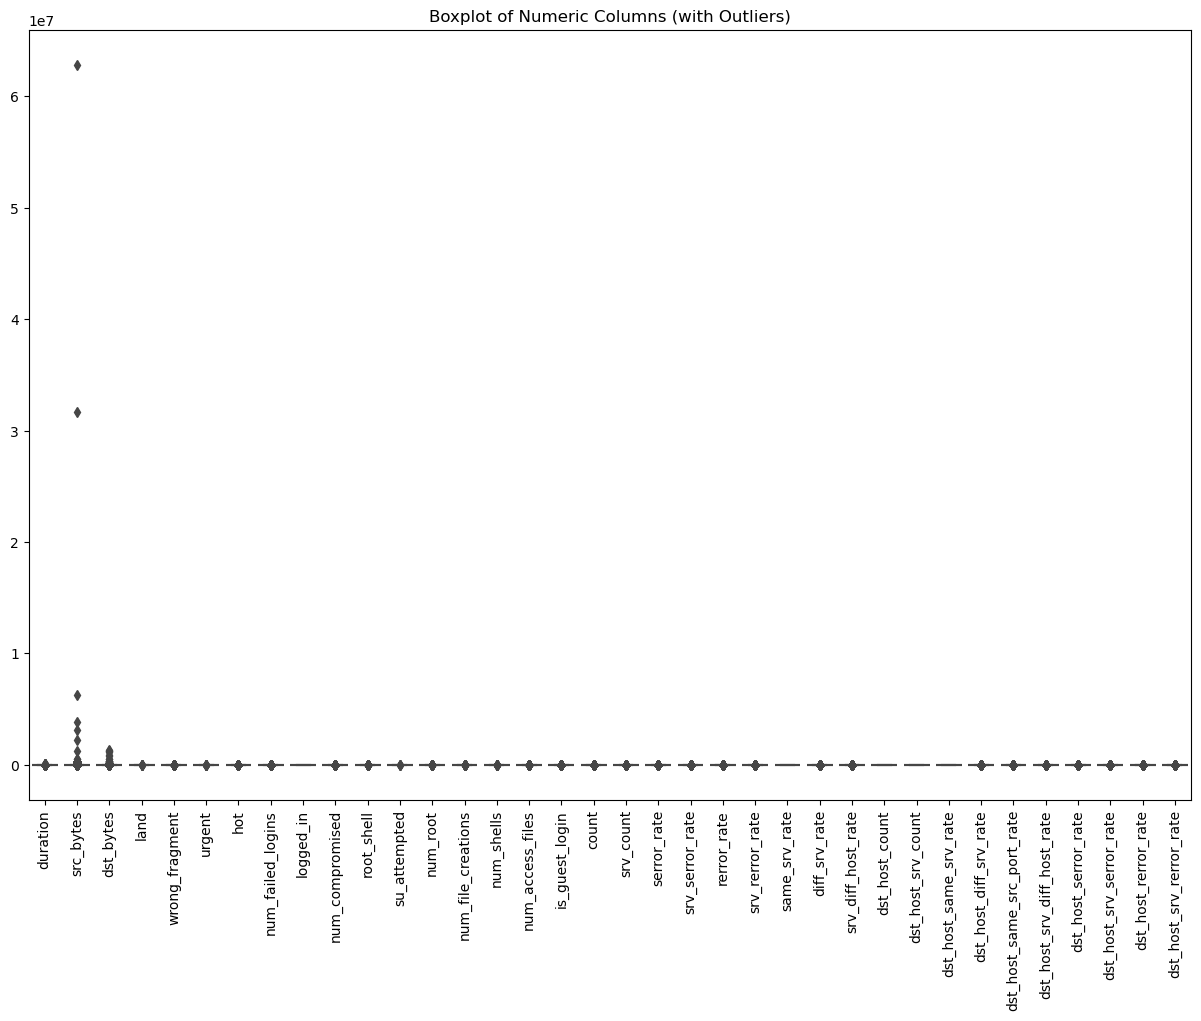

In [6]:
# Boxplot for numeric columns to visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=data[numeric_cols])
plt.title('Boxplot of Numeric Columns (with Outliers)')
plt.xticks(rotation=90)
plt.show()

## 4. Feature Transformation

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Apply feature transformation with StandardScaler
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Outlier treatment using IQR method
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = (data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))
data[numeric_cols][outliers] = np.nan
data = data.dropna()
print("\nAfter outlier treatment:")
print(data.describe())



After outlier treatment:
           duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  2.252300e+04  2.252300e+04  2.252300e+04  2.252300e+04    2.252300e+04   
mean   3.154743e-19 -3.627954e-18 -1.293445e-17 -9.464229e-18    1.009518e-17   
std    1.000022e+00  1.000022e+00  1.000022e+00  1.000022e+00    1.000022e+00   
min   -1.556083e-01 -2.199792e-02 -9.689475e-02 -1.763207e-02   -5.913158e-02   
25%   -1.556083e-01 -2.199792e-02 -9.689475e-02 -1.763207e-02   -5.913158e-02   
50%   -1.556083e-01 -2.188375e-02 -9.472786e-02 -1.763207e-02   -5.913158e-02   
75%   -1.556083e-01 -2.139115e-02 -6.858388e-02 -1.763207e-02   -5.913158e-02   
max    4.084141e+01  1.328029e+02  6.330470e+01  5.671483e+01    2.096962e+01   

             urgent           hot  num_failed_logins     logged_in  \
count  2.252300e+04  2.252300e+04       2.252300e+04  2.252300e+04   
mean  -7.255909e-18 -3.470217e-18      -5.363063e-18  1.577371e-19   
std    1.000022e+00  1.000022e+00 

/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_2181/1675745163.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols][outliers] = np.nan
/var/folders/9q/vqgvcv992rb1j75lkp2l_80h0000gn/T/ipykernel_2181/1675745163.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols][outliers] = np.nan


## 5. Data Preparation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [9]:
# Perform final feature selection and split into X and Y
X = data.drop('class', axis=1)
Y = data['class']

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_cols)],
    remainder='passthrough'
)

# Fit and transform on training data
X_train_encoded = preprocessor.fit_transform(X_train)

# Transform test data
X_test_encoded = preprocessor.transform(X_test)

## 6. Model Building - Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_encoded, Y_train)

# Make predictions
Y_train_pred = log_reg.predict(X_train_encoded)
Y_test_pred = log_reg.predict(X_test_encoded)

# Print training accuracy
train_accuracy = accuracy_score(Y_train, Y_train_pred)
print("\nTraining Accuracy (Logistic Regression):", train_accuracy)

# Print test accuracy
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print("Test Accuracy (Logistic Regression):", test_accuracy)


Training Accuracy (Logistic Regression): 0.9534354534354534
Test Accuracy (Logistic Regression): 0.9485016648168701


In [11]:
# Print confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred)
print("\nConfusion Matrix (Logistic Regression):")
print(conf_matrix)

# Print classification report
print("\nClassification Report (Logistic Regression):")
print(classification_report(Y_test, Y_test_pred))


Confusion Matrix (Logistic Regression):
[[2485   95]
 [ 137 1788]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     anomaly       0.95      0.96      0.96      2580
      normal       0.95      0.93      0.94      1925

    accuracy                           0.95      4505
   macro avg       0.95      0.95      0.95      4505
weighted avg       0.95      0.95      0.95      4505



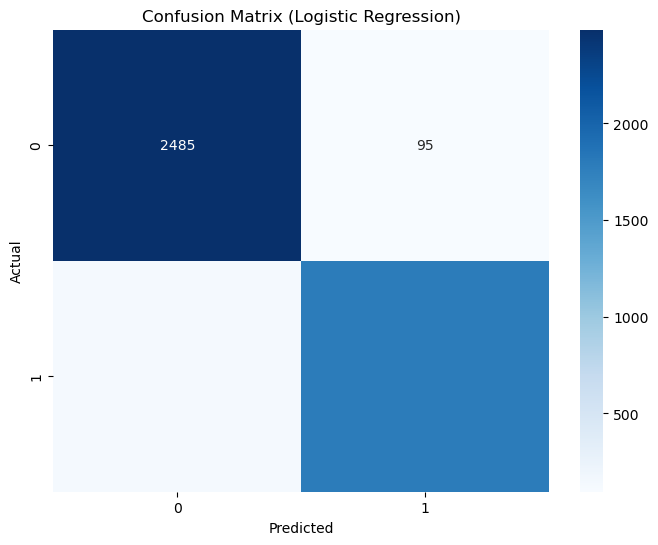

In [12]:
# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Model Building - Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_encoded, Y_train)

# Make predictions
Y_test_pred_rf = rf_model.predict(X_test_encoded)

# Print test accuracy
test_accuracy_rf = accuracy_score(Y_test, Y_test_pred_rf)
print("\nTest Accuracy (Random Forest Classifier):", test_accuracy_rf)


Test Accuracy (Random Forest Classifier): 0.9877913429522752


In [14]:
# Print confusion matrix
conf_matrix_rf = confusion_matrix(Y_test, Y_test_pred_rf)
print("\nConfusion Matrix (Random Forest Classifier):")
print(conf_matrix_rf)

# Print classification report
print("\nClassification Report (Random Forest Classifier):")
print(classification_report(Y_test, Y_test_pred_rf))



Confusion Matrix (Random Forest Classifier):
[[2553   27]
 [  28 1897]]

Classification Report (Random Forest Classifier):
              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      2580
      normal       0.99      0.99      0.99      1925

    accuracy                           0.99      4505
   macro avg       0.99      0.99      0.99      4505
weighted avg       0.99      0.99      0.99      4505



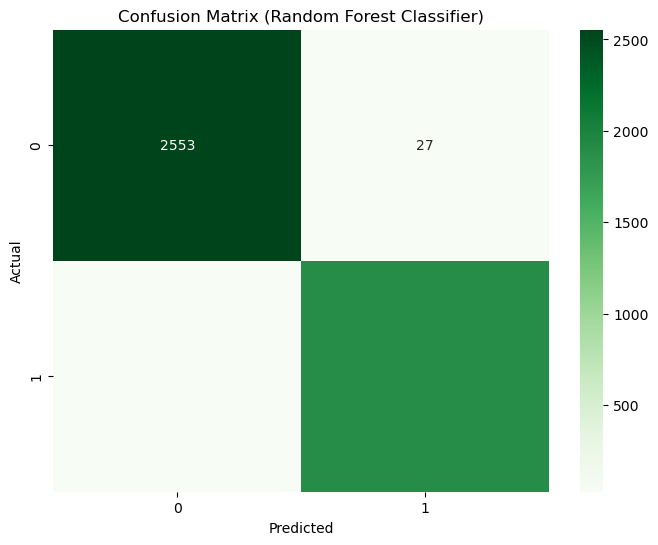

In [15]:
# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Random Forest Classifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Model Comparison

/Users/anxiousviking/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


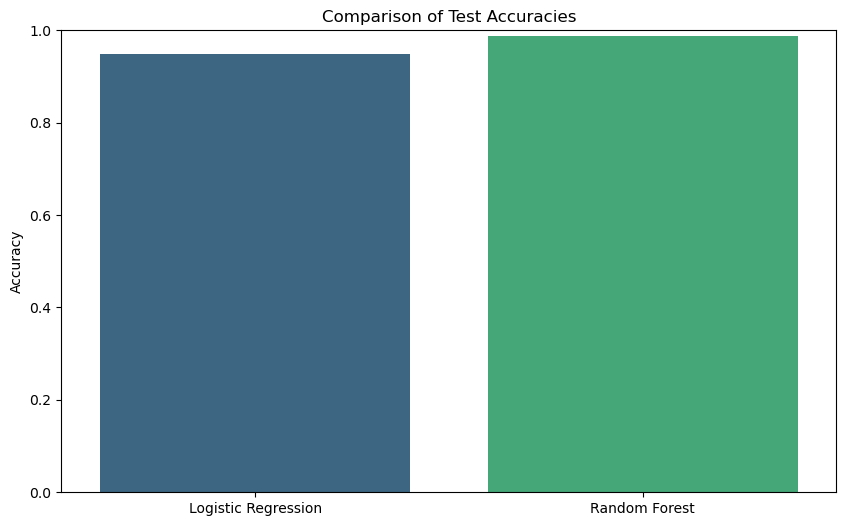

In [16]:
# Comparison of test accuracies
model_names = ['Logistic Regression', 'Random Forest']
test_accuracies = [test_accuracy, test_accuracy_rf]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=test_accuracies, palette='viridis')
plt.title('Comparison of Test Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [17]:
# Display the results of the predictions
results = pd.DataFrame({'Actual': Y_test, 'Predicted (Logistic Regression)': Y_test_pred, 'Predicted (Random Forest)': Y_test_pred_rf})
print("\nResults of Predictions:")
print(results)


Results of Predictions:
        Actual Predicted (Logistic Regression) Predicted (Random Forest)
16519  anomaly                         anomaly                   anomaly
15563   normal                          normal                    normal
11904  anomaly                         anomaly                   anomaly
5507    normal                          normal                    normal
4656   anomaly                         anomaly                   anomaly
...        ...                             ...                       ...
11909  anomaly                         anomaly                   anomaly
8734   anomaly                          normal                   anomaly
8497   anomaly                         anomaly                   anomaly
21453   normal                          normal                    normal
9393    normal                          normal                    normal

[4505 rows x 3 columns]


In [18]:
# Add a new column that shows whether the predictions from the two models match
results['Match'] = results['Predicted (Logistic Regression)'] == results['Predicted (Random Forest)']

# Print the results
print("\nResults with Match Column:")
print(results)


Results with Match Column:
        Actual Predicted (Logistic Regression) Predicted (Random Forest)  \
16519  anomaly                         anomaly                   anomaly   
15563   normal                          normal                    normal   
11904  anomaly                         anomaly                   anomaly   
5507    normal                          normal                    normal   
4656   anomaly                         anomaly                   anomaly   
...        ...                             ...                       ...   
11909  anomaly                         anomaly                   anomaly   
8734   anomaly                          normal                   anomaly   
8497   anomaly                         anomaly                   anomaly   
21453   normal                          normal                    normal   
9393    normal                          normal                    normal   

       Match  
16519   True  
15563   True  
11904   True  

In [19]:
# Get only the rows where the predictions don't match
mismatches = results[results['Match'] == False]

# Get the original data for those instances
original_data = X_test.loc[mismatches.index]

# Add the original data to the mismatches DataFrame
mismatches = pd.concat([mismatches, original_data], axis=1)

# Print the mismatches
print("\nMismatched Predictions with Original Data:")
print(mismatches)


Mismatched Predictions with Original Data:
        Actual Predicted (Logistic Regression) Predicted (Random Forest)  \
8327    normal                         anomaly                    normal   
8700   anomaly                          normal                   anomaly   
16949   normal                         anomaly                    normal   
8305    normal                         anomaly                    normal   
14423   normal                         anomaly                    normal   
...        ...                             ...                       ...   
9096   anomaly                          normal                   anomaly   
15252   normal                         anomaly                    normal   
11722  anomaly                          normal                   anomaly   
14635   normal                         anomaly                    normal   
8734   anomaly                          normal                   anomaly   

       Match  duration protocol_type   serv